### This Notebook is to show the following common Deep Learning practices:
#### Deep Neural Networks
#### Stocastic Gradient Descent (SGD)
#### Overfitting and Underfitting
#### Dropout and Batch Normalization
#### Binary Classification

First, explore the deep neural networks and SGD

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

fuel = pd.read_csv('./data/fuel.csv')

X = fuel.copy()
# Remove target
y = X.pop('FE')

preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse_output=False),
     make_column_selector(dtype_include=object)),
)

X = preprocessor.fit_transform(X)
y = np.log(y) # log transform target instead of standardizing

input_shape = [X.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [50]


In [8]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(128, activation='relu'),    
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])

C:\Users\jarvi\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(
    optimizer='adam',
    loss='mae',
)

In [12]:
history = model.fit(
    X, y,
    validation_data=(X, y),
    batch_size=128,
    epochs=200
)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 2.8348 - val_loss: 1.6063
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0972 - val_loss: 0.9432
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6351 - val_loss: 0.4520
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3744 - val_loss: 0.3218
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2414 - val_loss: 0.2130
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1825 - val_loss: 0.1561
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1452 - val_loss: 0.1281
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1235 - val_loss: 0.1088
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1053 - val_loss: 0.0945
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0929 - val_loss: 0.0871
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0870 - val_loss: 0.0828
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0788 - val_lo

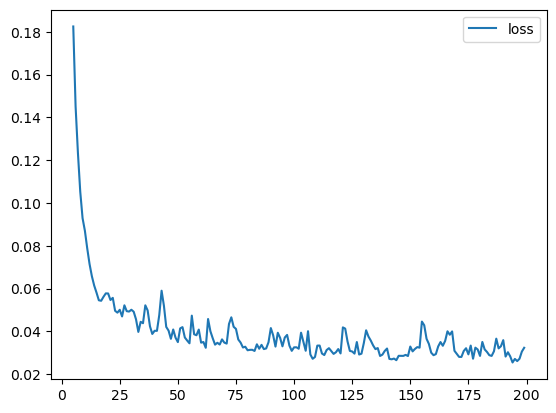

In [13]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5. You can change this to get a different view.
history_df.loc[5:, ['loss']].plot();

The learning curves have levelled off, there won't usually be any advantage to training for additional epochs

Explore overfitting and underfitting

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('./data/spotify.csv/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


C:\Users\jarvi\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Minimum Validation Loss: 0.1956


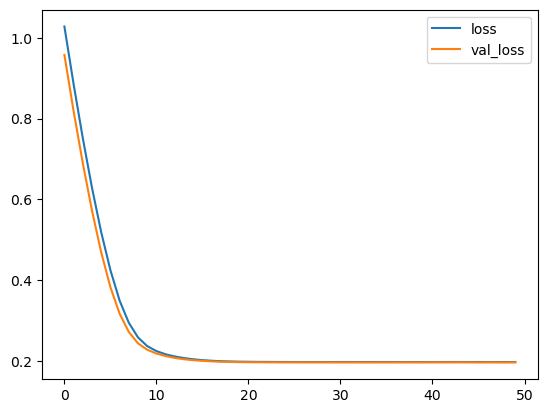

In [17]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

To take a closer look at the loss, we start from epoch 10

Minimum Validation Loss: 0.1956


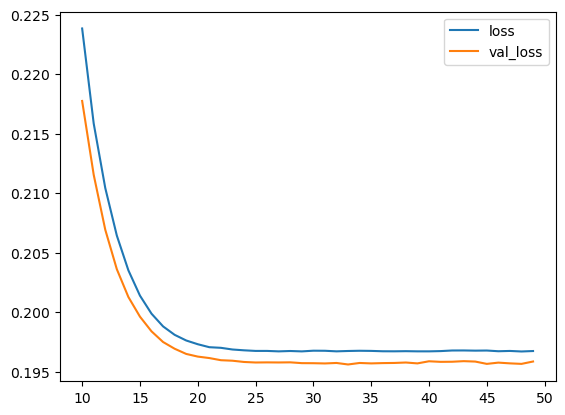

In [18]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case.

Epoch 1/50


C:\Users\jarvi\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2558 - val_loss: 0.2073
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2038 - val_loss: 0.2004
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1981 - val_loss: 0.1980
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1948 - val_loss: 0.1967
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1929 - val_loss: 0.1970
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1906 - val_loss: 0.1962
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1892 - val_loss: 0.1955
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1882 - val_loss: 0.1951
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1870 - val_loss: 0.1953
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1866 - val_loss: 0.1960
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1857 - val_loss: 0.1950
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1846 - val_loss: 0.1947


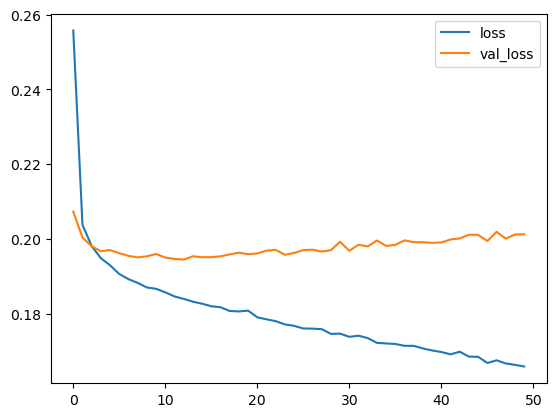

In [19]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping.

In [20]:
early_stopping = callbacks.EarlyStopping(
    min_delta = 0.001,
    patience = 5,
    restore_best_weights = True,
)

Epoch 1/50


C:\Users\jarvi\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2185 - val_loss: 0.2014
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1984 - val_loss: 0.1973
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1941 - val_loss: 0.1965
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1918 - val_loss: 0.1958
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1897 - val_loss: 0.1951
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1887 - val_loss: 0.1959
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1871 - val_loss: 0.1952
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1859 - val_loss: 0.1952
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1853 - val_loss: 0.1957
Minimum Validation Loss: 0.1951


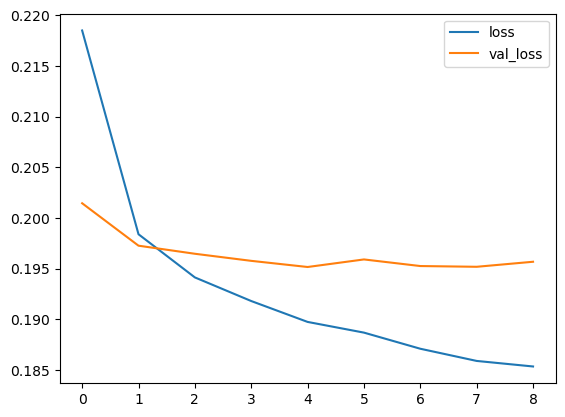

In [21]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

The early stopping callback did stop the training once the network began overfitting. Moreover, by including restore_best_weights we still get to keep the model where validation loss was lowest.

Next, we try to add dropout to the Spotify model

In [22]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

C:\Users\jarvi\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Minimum Validation Loss: 0.1907


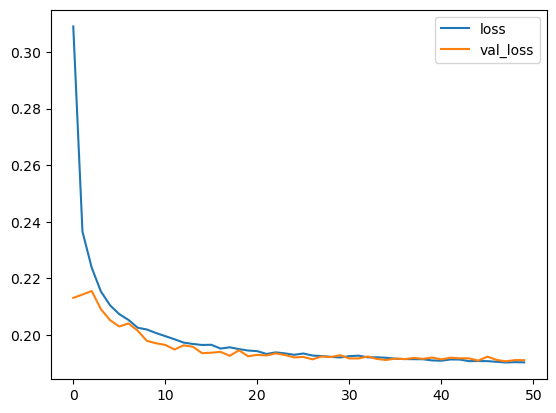

In [23]:
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

From the learning curves, you can see that the validation loss remains near a constant minimum even though the training loss continues to decrease. So we can see that adding dropout did prevent overfitting this time. Moreover, by making it harder for the network to fit spurious patterns, dropout may have encouraged the network to seek out more of the true patterns, possibly improving the validation loss some as well.

Now, we are exploring batch normalization using the concrete data

In [24]:
import pandas as pd

concrete = pd.read_csv('./data/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

C:\Users\jarvi\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Minimum Validation Loss: 3.9526


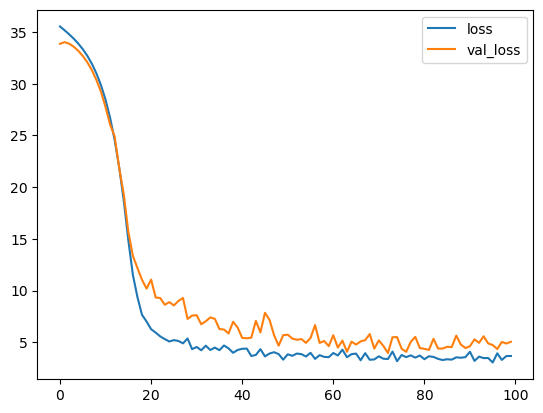

In [26]:
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

By adaptively scaling the data as it passes through the network, batch normalization can let you train models on difficult datasets.

Finally, we will look at deep learning application for binary classification

In [28]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('./data/hotel.csv/hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

Epoch 1/200


C:\Users\jarvi\miniconda3\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - binary_accuracy: 0.7728 - loss: 0.4774 - val_binary_accuracy: 0.7890 - val_loss: 0.4381
Epoch 2/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - binary_accuracy: 0.8026 - loss: 0.4212 - val_binary_accuracy: 0.8132 - val_loss: 0.4061
Epoch 3/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - binary_accuracy: 0.8104 - loss: 0.4079 - val_binary_accuracy: 0.8166 - val_loss: 0.3990
Epoch 4/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - binary_accuracy: 0.8136 - loss: 0.4008 - val_binary_accuracy: 0.8170 - val_loss: 0.3938
Epoch 5/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.8150 - loss: 0.3967 - val_binary_accuracy: 0.8160 - val_loss: 0.3918
Epoch 6/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - binary_accuracy: 0.8185 - loss: 0.3909 - val_binary_accuracy: 0.8221 - val_loss: 0.3868
Epoch 7/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.8197 - loss: 0.3869 - val_binary_accuracy: 0.8226 - val_loss: 0.3835
Epoch 8/

<Axes: title={'center': 'Accuracy'}>

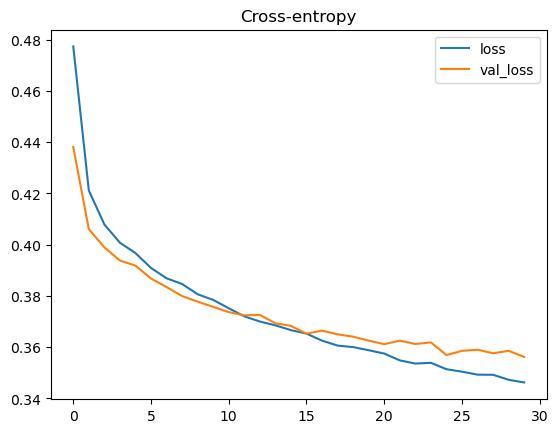

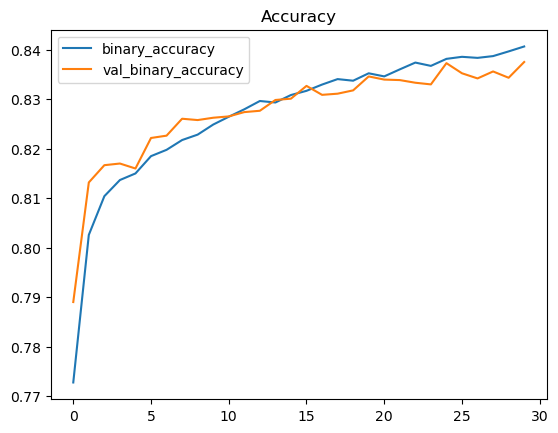

In [29]:
from tensorflow import keras
from tensorflow.keras import layers

# YOUR CODE HERE: define the model given in the diagram
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape), 
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(0.3), 
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(0.3), 
    layers.Dense(1, activation='sigmoid'),]    
)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

Though we can see the training loss continuing to fall, the early stopping callback prevented any overfitting. Moreover, the accuracy rose at the same rate as the cross-entropy fell, so it appears that minimizing cross-entropy was a good stand-in. All in all, it looks like this training was a success!